# 1. fetch names from wikidata (see https://www.wikidata.org/wiki/Wikidata:Main_Page for more)

In [1]:
from typing import List
import requests
import re


def fetch_names(limit: int = 100, region: str = "Q183") -> list:
    url = "https://query.wikidata.org/sparql"
    query = f"""
    SELECT DISTINCT ?person ?personLabel WHERE {{
      ?person wdt:P31 wd:Q5;  # Q5 stands for human
        (wdt:P27|wdt:P19|wdt:P551) wd:{region}.  # P27 for citizenship, P19 for place of birth, P551 for place of residence, Q183 for Germany
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],de". }}
    }}
    LIMIT {limit}
    """
    headers = {'User-Agent': 'Mozilla/5.0', 'Accept': 'application/json'}
    response = requests.get(url, headers=headers, params={'query': query, 'format': 'json'})
    data = response.json()
    return [result['personLabel']['value'] for result in data['results']['bindings']]

def name_pattern(name: str) -> bool:
    match_object = re.match(pattern=r"[A-Z][a-z]+", string=name)
    if match_object:
        return match_object.group() == name
    return False

def clean(names: List[str]) -> List[str]:
    # unfold "Hans-Peter" -> ["Hans", "Peter"]
    names_unfolded = []
    for name in names:
        if "-" in name:
            names_unfolded.extend(name.split("-"))
        else:
            names_unfolded.append(name)
    return [f for f in names_unfolded if (name_pattern(f))]

In [2]:
"""
Q183: germany
Q36: poland
Q41: greece
Q43: turkey
"""
region = "Q183"
names = fetch_names(limit=200_000, region=region)
"""
names_new = fetch_names(limit=50, region=region)
names.extend(names_new)
names = list(set(names))
print(len(names))
"""
names_valid = [n for n in names if len(n.split()) == 2]  # for simplification. TODO: Sabine von Eltz etc
names_valid = list(set(names_valid))  # uniuqes

first_names = clean([n.split()[0] for n in names_valid])
last_names = clean([n.split()[1] for n in names_valid])

with open(f"last_names_{region}.txt", "w", encoding="utf8") as f:
    f.write("\n".join(last_names))
with open(f"first_names_{region}.txt", "w", encoding="utf8") as f:
    f.write("\n".join(first_names))

# 2. cluster names by their embeddings

In [3]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import pandas as pd


def cluster(embeddings, n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    pred = kmeans.fit_predict(embeddings, )

    clusters = [[] for _ in range(n_clusters)]
    for i in range(n_clusters):
        for j in range(len(pred)):
            if pred[j] == i:
                clusters[i].append(first_names_common[j])
    return clusters


# find first names that occur at least 10 times
first_names_ser = pd.Series(first_names)
first_names_count = first_names_ser.value_counts()
first_names_common = list(first_names_count[first_names_count > 10].index)

# embed each name
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(first_names_common)

# cluster names into two clusters and print some members
n_clusters = 2
clusters = cluster(embeddings=embeddings, n_clusters=n_clusters)
for c in clusters:
    print(c[:10])

c:\Users\milan\OneDrive\Documents\portfolio\llama_index_projects\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Hans', 'Karl', 'Peter', 'Wilhelm', 'Michael', 'Heinrich', 'Wolfgang', 'Hermann', 'Heinz', 'Georg']
['Maria', 'Elisabeth', 'Sabine', 'Barbara', 'Ursula', 'Anna', 'Susanne', 'Eva', 'Claudia', 'Katharina']


c:\Users\milan\OneDrive\Documents\portfolio\llama_index_projects\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\milan\OneDrive\Documents\portfolio\llama_index_projects\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


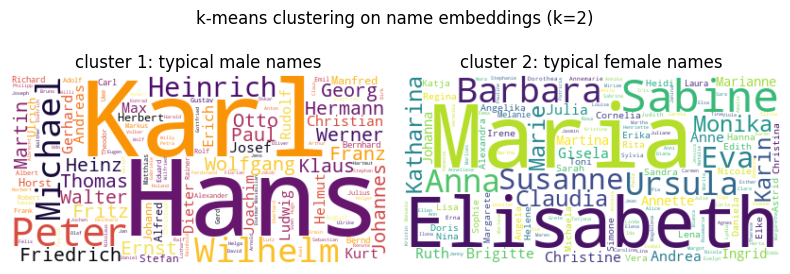

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(8, 3))

wordcloud = WordCloud(width=400, height=200, background_color='white', colormap="inferno").generate(' '.join(clusters[0][:200]))
axs[0].set_title("cluster 1: typical male names")
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis('off')

wordcloud = WordCloud(width=400, height=200, background_color='white', colormap="viridis").generate(' '.join(clusters[1][:200]))
axs[1].set_title("cluster 2: typical female names")
axs[1].imshow(wordcloud, interpolation='bilinear')
axs[1].axis('off')

fig.suptitle("k-means clustering on name embeddings (k=2)")
plt.tight_layout()
plt.savefig("name_clusters.png")

- when clustering with 2 clusters, each cluster is dominated by one gender
- we can use the fitted clusters to infer genders for names
- doesn't work 100% correct, especially for rare names

# 3. other use cases

In [8]:
# use names to e.g. remove them from a vocabulary
# example vocabulary: list of 1_908_815 german words from
# https://gist.github.com/MarvinJWendt/2f4f4154b8ae218600eb091a5706b5f4#file-wordlist-german-txt
with open("../wordlist-german.txt", "r") as f:
    words = f.read().split("\n")
words_capitalized = [w for w in words if name_pattern(w)][:100]  # first 100 for simplification, actually 1_131_052
all_names = list(set(first_names + last_names))[:100]  # first 100 or simplification
words = [w for w in words if w not in all_names]